# Example contour Analysis
Here we'll do some plotting and data exploration of contours.

In [13]:
# core
import sys, os, re, csv
import numpy as np
import pandas as pd
from pathlib import Path
# plotting
import matplotlib
import matplotlib.pyplot as plt
if sys.platform == 'darwin':
    %config InlineBackend.figure_format ='retina'
%matplotlib inline
# vision and analysis
import cv2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Custom imagetools
module_path = Path("../Scripts/")
if module_path.absolute().as_posix() not in sys.path:
    sys.path.append(module_path.as_posix())
from imagetools import *

For an easy dataset, I'll work with the dragonfly wing data.

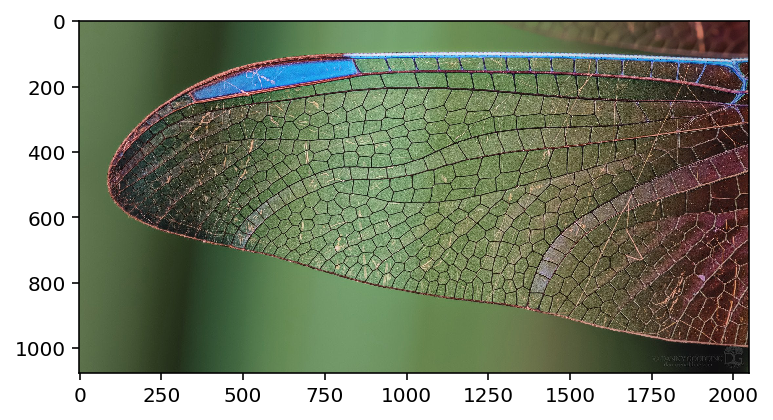

In [14]:
dragonfly = cv2.imread("../Data/test_images/dragonflywing.jpg")
plt.imshow(dragonfly);

After starting at 

```bash
--k_blur 5 
--C 10 
--blocksize 99 
--k_laplacian 3 
--k_dilate 3 
--k_gradient 3 
--k_foreground 3
```
 and playing with the parameters on using `MCF-GUI.py`, I was able to get the following contour data

In [15]:
dragonfly_contour_DF = pd.read_json("../Data/test_images/dragonflywing.contour_data.json")
dragonfly_contour_DF.head()

uuid4  \
0  1314cd58926c44818c5a906fce639ddd   
1  6f48d302a8834ceba2e866bc0fb9f7f1   
2  cd5a5691ca6e4706ba2930e85e6e8816   
3  5c2eaffc958e453881a52331f053fed6   
4  edc896652c504f0781db9d450bf0a0c1   

                                             contour   C  kBlur  blocksize  \
0  [[[1335, 335]], [[1334, 336]], [[1324, 336]], ...  17      2          4   
1  [[[1211, 357]], [[1210, 358]], [[1207, 358]], ...  17      2          4   
2  [[[1151, 377]], [[1150, 378]], [[1149, 378]], ...  17      2          4   
3  [[[1099, 399]], [[1098, 400]], [[1097, 400]], ...  17      2          4   
4  [[[1046, 423]], [[1045, 424]], [[1043, 424]], ...  17      2          4   

   kDilate  kGradient  kForeground    area    moment_XY  ... bbox_x  bbox_y  \
0        2          2            3  3008.0  [1308, 365]  ...   1283     335   
1        2          2            3  2726.0  [1189, 388]  ...   1162     357   
2        2          2            3  2437.5  [1132, 407]  ...   1109     377   
3        2          2            3  1933.0  [1077, 426]  ...   1058     399   
4        2          2            3  1787.5  [1019, 446]  ...    999     423   

   bbox_h  bbox_w  bbox_area  aspect_ratio  \
0      72      63       4536      0.875000   
1      72      62       4464      0.861111   
2      71      59       4189      0.830986   
3      61      53       3233      0.868852   
4      63      45       2835      0.714286   

                                         convex_hull  convexity  solidity  \
0  [[[1337, 336]], [[1354, 387]], [[1354, 389]], ...      False  0.949495   
1  [[[1212, 357]], [[1214, 358]], [[1216, 361]], ...      False  0.965468   
2  [[[1152, 377]], [[1154, 378]], [[1176, 412]], ...      False  0.957760   
3  [[[1101, 400]], [[1104, 405]], [[1114, 425]], ...      False  0.966742   
4  [[[1048, 423]], [[1050, 424]], [[1051, 425]], ...      False  0.964392   

   equivalent_diameter  
0            61.886223  
1            58.913929  
2            55.709258  
3            49.610201  
4            47.706558  

[5 rows x 22 columns]

**In order to work with the contours using `cv2`, we first have to convert them to `np.array`s.** This is accomplished with the `.apply` method:

In [16]:
dragonfly_contour_DF["contour"] = dragonfly_contour_DF["contour"].apply(np.array)

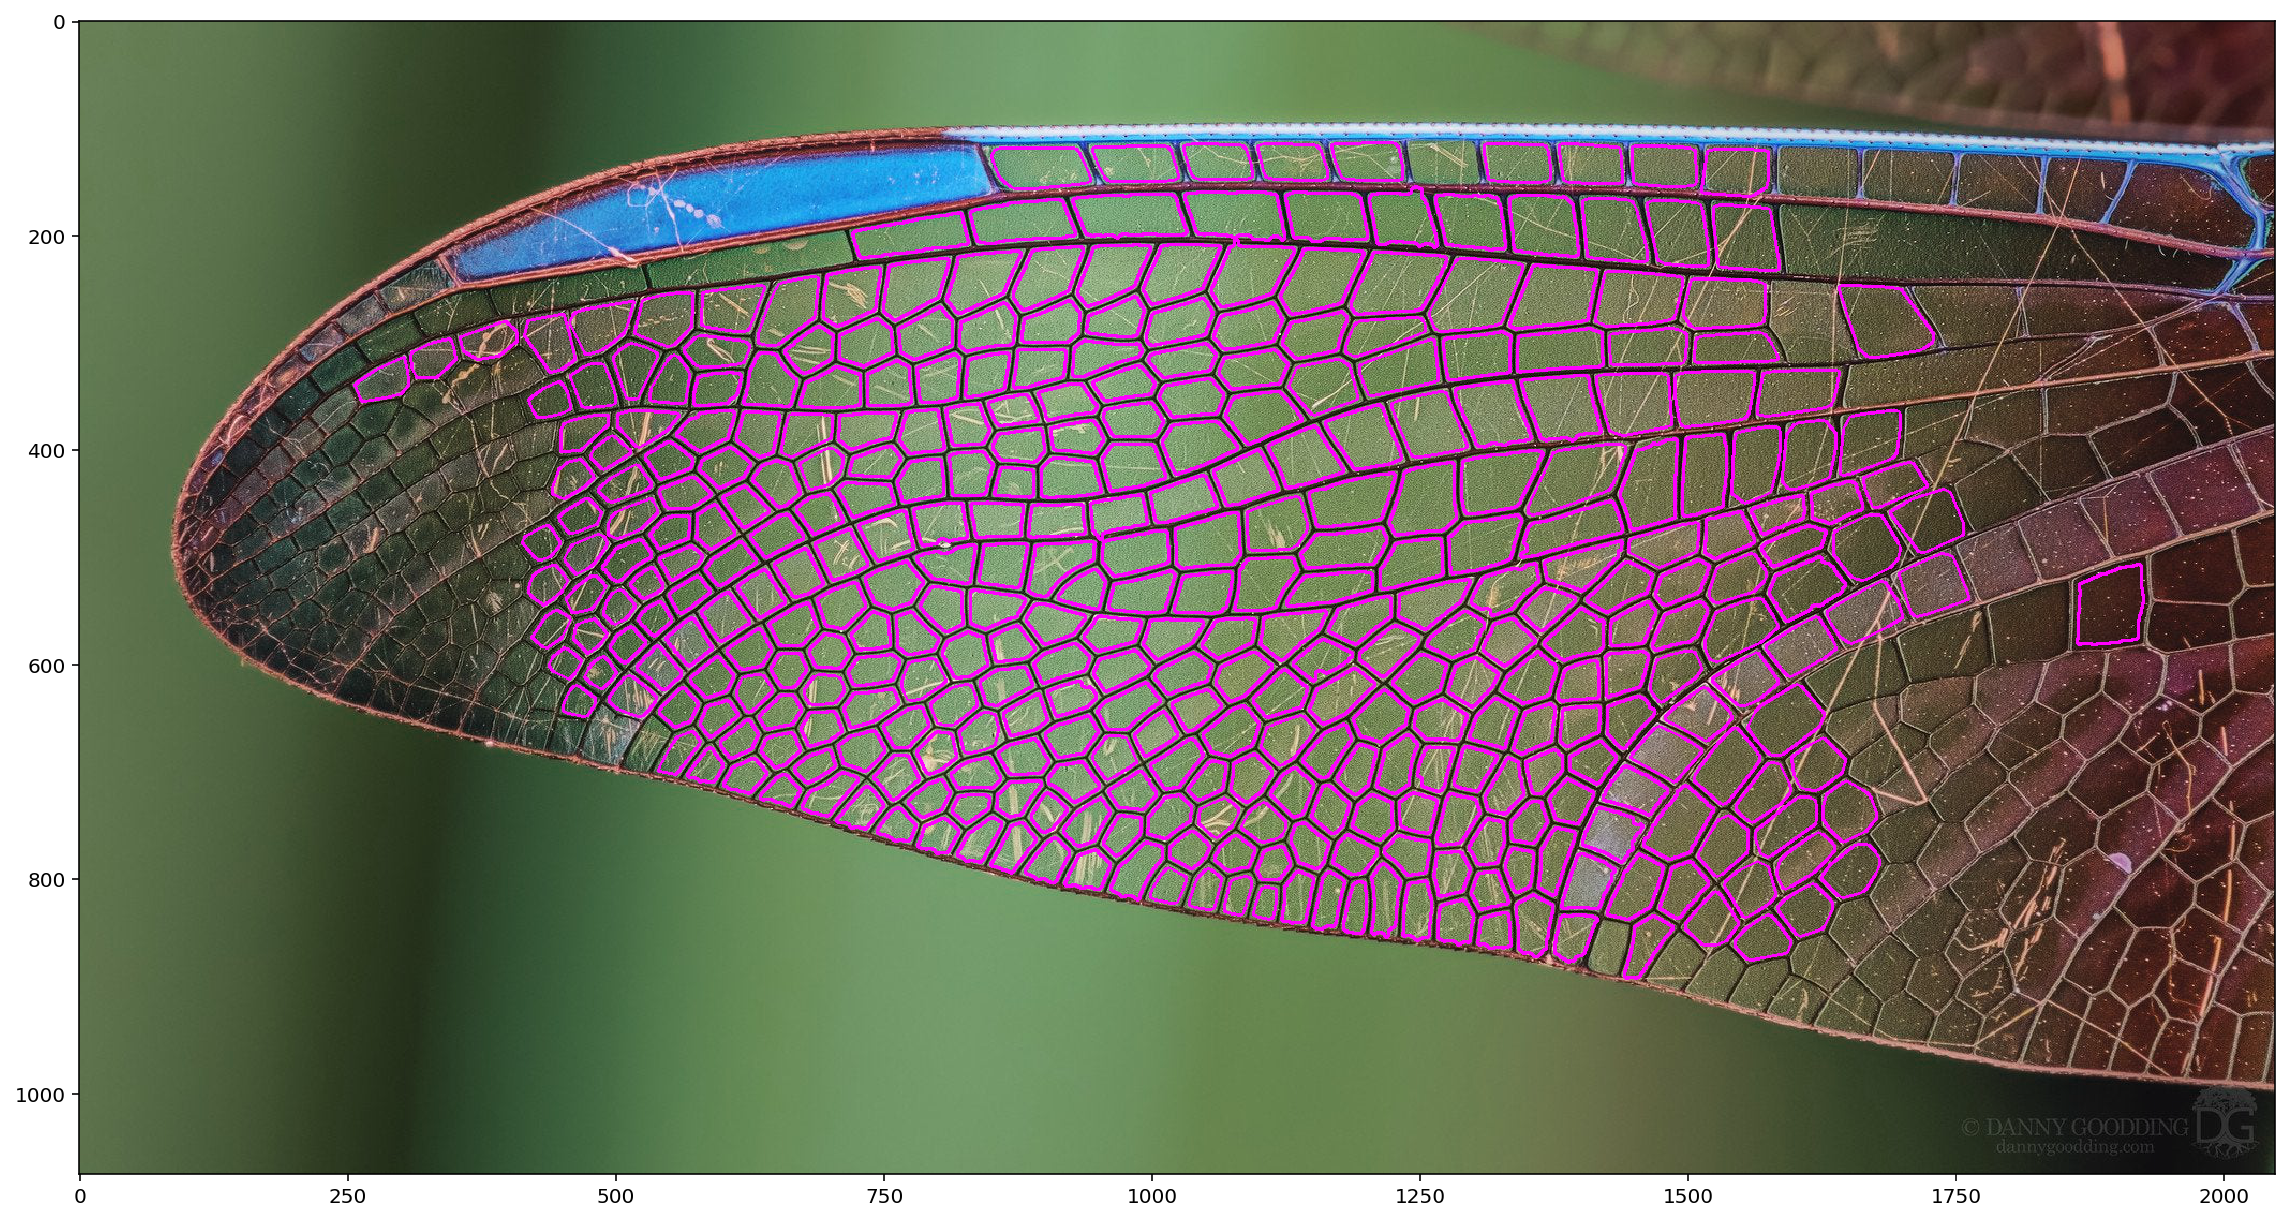

In [17]:
fix, ax = plt.subplots(figsize=(16,16))

canvas = dragonfly.copy()
cv2.drawContours(canvas, dragonfly_contour_DF["contour"].values, -1, (255, 0, 255), 2)

ax.imshow(canvas)
plt.tight_layout()

We can use the contours and the image to get the color values of the contours.

In [18]:
R = []
B = []
G = []
for c in dragonfly_contour_DF["contour"]:
    r,b,g = getContourRBG(c, dragonfly)
    R.append(r)
    B.append(b)
    G.append(g)
dragonfly_contour_DF["meanR"] = R
dragonfly_contour_DF["meanB"] = B
dragonfly_contour_DF["meanG"] = G

In [19]:
dragonfly_contour_DF["moment_X"] = np.array(flatten(dragonfly_contour_DF["moment_XY"].values)).reshape((len(dragonfly_contour_DF),2))[:,0]
dragonfly_contour_DF["moment_Y"] = np.array(flatten(dragonfly_contour_DF["moment_XY"].values)).reshape((len(dragonfly_contour_DF),2))[:,1]

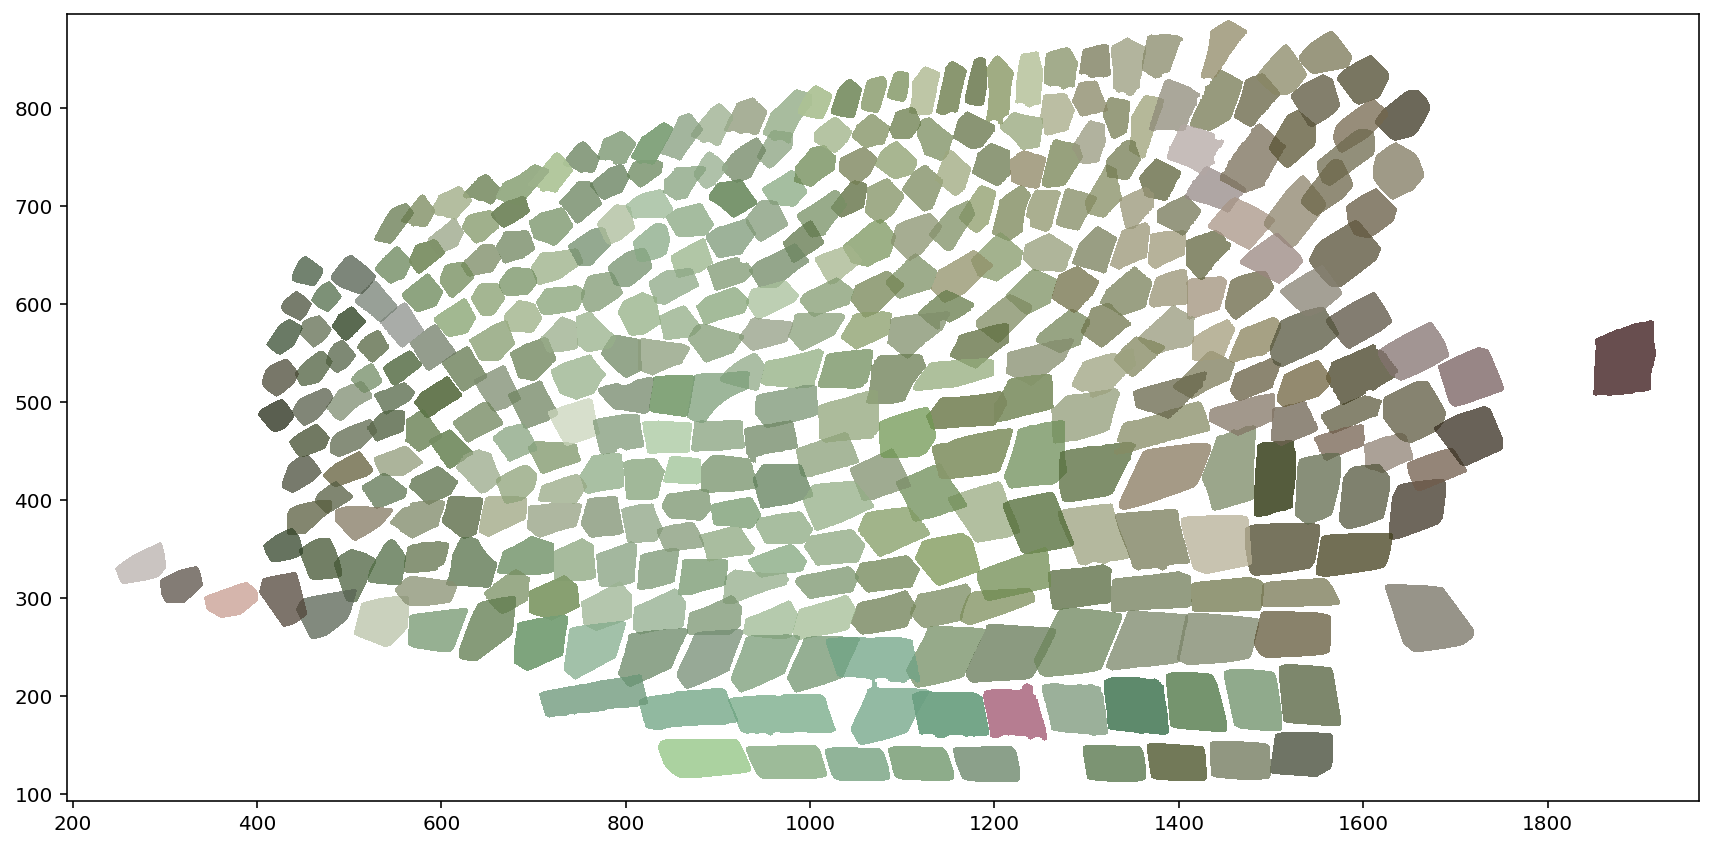

In [20]:
fig, ax = plt.subplots(figsize=(12,6))
canvas = dragonfly.copy()
color = dragonfly_contour_DF[["meanR", "meanB", "meanG"]].values/255

contourScatter(x=dragonfly_contour_DF["moment_X"], 
               y=dragonfly_contour_DF["moment_Y"],
               contours=[c for c in dragonfly_contour_DF["contour"]], 
               color=color, linewidth=-1, ax=ax, zoom=0.5, alpha=0.75)

plt.tight_layout()

You'll notice that the vertical placement of the contours is different here because the contours have coordinates from OpenCV, which has an upper left hand origin, while matplotlib uses a lower left origin.

Now, with some information on the size, shape, and color of the elements identified in the image, we can plot them in a PCA.

In [21]:
to_pca = dragonfly_contour_DF[["area", "aspect_ratio", "solidity", "meanR", "meanB", "meanG"]]
standardized = StandardScaler().fit_transform(to_pca)

In [22]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(standardized)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
pcdf = pd.concat([principalDf, dragonfly_contour_DF[['contour']]], axis = 1)
pcdf.head()

PC1       PC2                                            contour
0 -1.695242 -1.170287  [[[1335, 335]], [[1334, 336]], [[1324, 336]], ...
1 -1.718546 -1.176955  [[[1211, 357]], [[1210, 358]], [[1207, 358]], ...
2  0.417548 -0.771121  [[[1151, 377]], [[1150, 378]], [[1149, 378]], ...
3 -0.417023 -0.436038  [[[1099, 399]], [[1098, 400]], [[1097, 400]], ...
4 -1.240387 -0.797211  [[[1046, 423]], [[1045, 424]], [[1043, 424]], ...

In [23]:
pc1var, pc2var = pca.explained_variance_ratio_

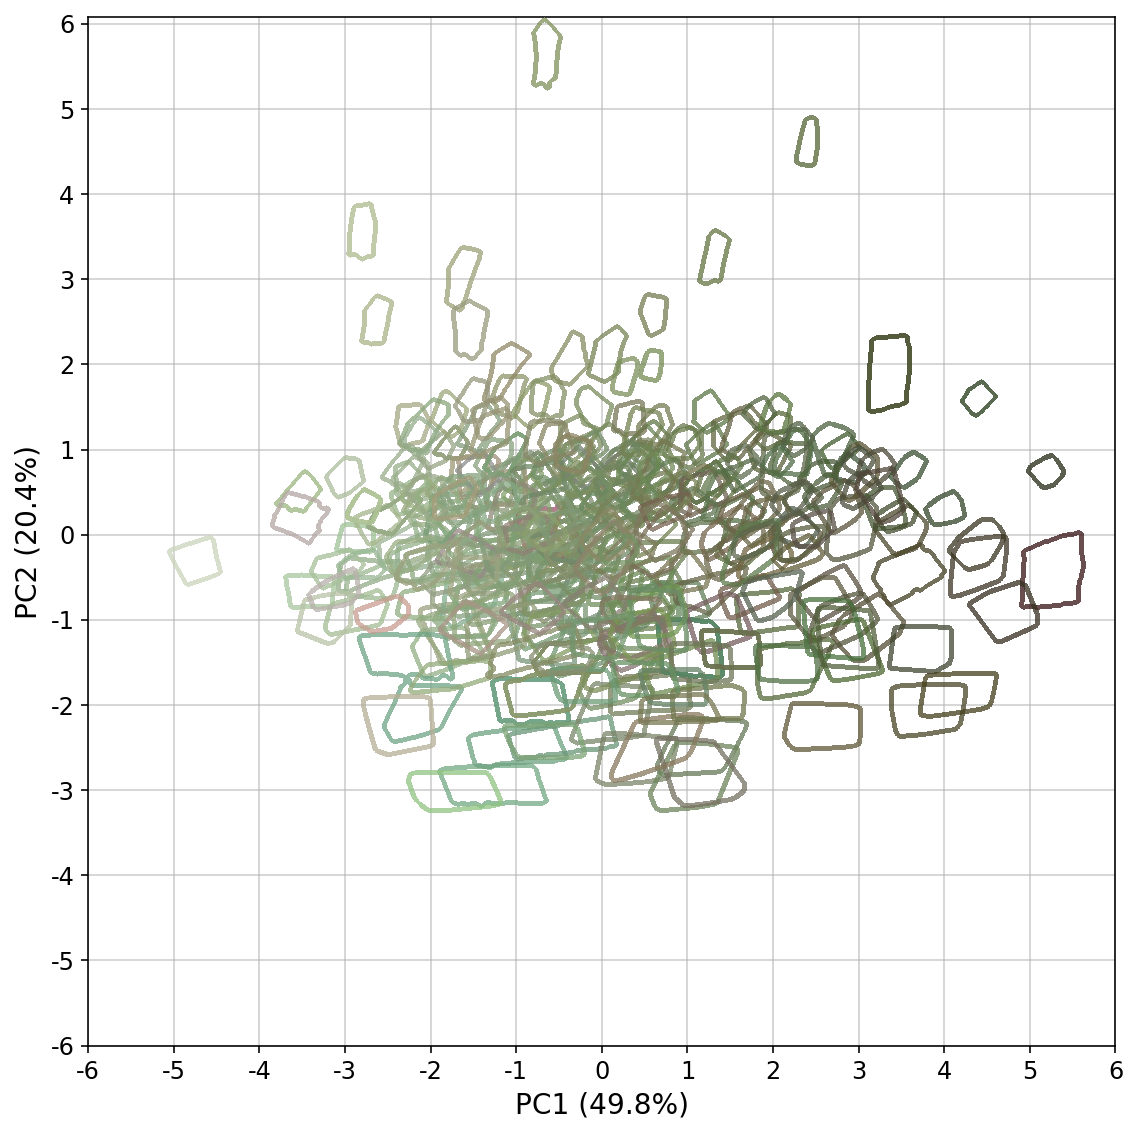

In [24]:
fig, ax = plt.subplots(figsize=(8,8))

contourScatter(x=pcdf["PC1"], 
               y=pcdf["PC2"],
               contours=pcdf["contour"], 
               color=color, linewidth=3, ax=ax, zoom=0.5, alpha=0.75)

ax.set_xticks(range(-6,7,1))
ax.set_xticklabels(range(-6,7,1), size=12)
ax.set_yticks(range(-6,7,1))
ax.set_yticklabels(range(-6,7,1), size=12)

ax.grid(linewidth=1, alpha=0.5)

ax.set_xlabel("PC1 ({:.1%})".format(pc1var), size=14)
ax.set_ylabel("PC2 ({:.1%})".format(pc2var), size=14)
plt.tight_layout()